In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import pandas as pd

In [2]:
!pip install gdown

  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
Using cached gdown-5.2.0-py3-none-any.whl (18 kB)


In [3]:
!pip install diffusers accelerate

  Using cached diffusers-0.33.1-py3-none-any.whl.metadata (19 kB)
  Using cached accelerate-1.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
Using cached diffusers-0.33.1-py3-none-any.whl (3.6 MB)
Using cached accelerate-1.6.0-py3-none-any.whl (354 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.2/484.2 kB 13.3 MB/s eta 0:00:0000:01
Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (792 kB)
Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)


In [4]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load Dataset

In [5]:
img_size = 128

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

dataset = datasets.CelebA(root='celeba/', split="train", target_type='attr', download=True, transform=transform)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

Files already downloaded and verified


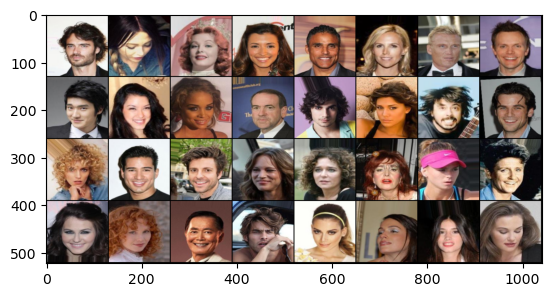

In [6]:
from matplotlib import pyplot as plt
x, y = next(iter(train_dataloader))

grid = make_grid(x, normalize=True, scale_each=False)
plt.imshow(grid.permute(1, 2, 0).numpy())

# Conditional Model w/ Diffusers

In [8]:
from diffusers import DDPMScheduler, UNet2DModel

device = "cuda" if torch.cuda.is_available() else "cpu"

logging.info("Using device: {}".format(device))

class ClassConditionedUnet(nn.Module):
    def __init__(self, class_attr_dim=40, class_emb_size=5, img_size=128):
        super().__init__()
        
        self.class_emb = nn.Linear(class_attr_dim, class_emb_size)
        
        self.model = UNet2DModel(
            sample_size=img_size, # Image resolution
            in_channels=3+class_emb_size,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 256),
            down_block_types=(
                "DownBlock2D",        # a regular ResNet downsampling block
                "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
                "AttnDownBlock2D"
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",          # a regular ResNet upsampling block
            ),
        )
        
    def forward(self, x, t, class_attr):
        bs, ch, w, h = x.shape
        
        # logging.info(f"X: {x.device}, t: {t.device}, class_attr: {class_attr.device}")
        
        class_cond = self.class_emb(class_attr.float()) # Shape (batch, 5)
        
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h) # Shape (batch, 5, img_size, img_size)
        
        net_input = torch.cat([x, class_cond], dim=1) # Shape (batch, 8, img_size, img_size)
        
        return self.model(net_input, t).sample

2025-05-13 17:50:47,966 - INFO - Using device: cuda


# Training / Sampling

In [9]:
from accelerate import Accelerator

accelerator = Accelerator()

2025-05-13 17:50:51,483 - WARNING - Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [10]:
n_epochs = 10

diffusion_model = ClassConditionedUnet(class_attr_dim=40, class_emb_size=20, img_size=128)

trainable_params = sum(
    p.numel() for p in diffusion_model.parameters() if p.requires_grad
)

print("total no.of parameters in unet model = ", trainable_params)

total no.of parameters in unet model =  26967223


In [11]:
diffusion_model.load_state_dict(torch.load("./diffusion_outputs/model_epoch_10_ckpt.pth"))

<All keys matched successfully>

In [12]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-3)

In [13]:
optimizer = accelerator.prepare(torch.optim.Adam(diffusion_model.parameters(), lr=1e-5))

In [14]:
train_dataloader, diffusion_model, noise_scheduler, optimizer = accelerator.prepare(
    train_dataloader,
    diffusion_model,
    noise_scheduler,
    optimizer
)

## Core Training Loop

In [13]:
losses = []

In [14]:
loss_fn = nn.MSELoss()

# ensure dir exists
from pathlib import Path
Path("./diffusion_outputs").mkdir(parents=True, exist_ok=True)

In [ ]:
diffusion_model.train()

for epoch in range(n_epochs):
    if epoch == 0 or epoch == 1 or epoch == 2:
        continue
    logging.info(f"Training... Epoch {epoch + 1}")
    for x,y in tqdm(train_dataloader):
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device) # Generate timestep for each batch
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        
        pred = diffusion_model(noisy_x, timesteps, y)
        
        loss = loss_fn(pred, noise)
        
        # Backprop
        optimizer.zero_grad()
        accelerator.backward(loss)
        optimizer.step()
        
        losses.append(loss.item())

        if len(losses) % 100 == 0:
            torch.save(diffusion_model.state_dict(), f"./diffusion_outputs/granular_checkpoints/model_step_{len(losses)}_ckpt.pth")
    
    
    avg_loss = sum(losses[-500:]) / 500
    print(f"Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss:.4f}")
    torch.save(diffusion_model.state_dict(), f"./diffusion_outputs/model_epoch_{epoch+1}_ckpt.pth")
    
plt.plot(losses)

2025-05-10 20:47:42,984 - INFO - Training... Epoch 4
 90%|████████▉ | 2288/2544 [5:03:14<33:53,  7.94s/it]  

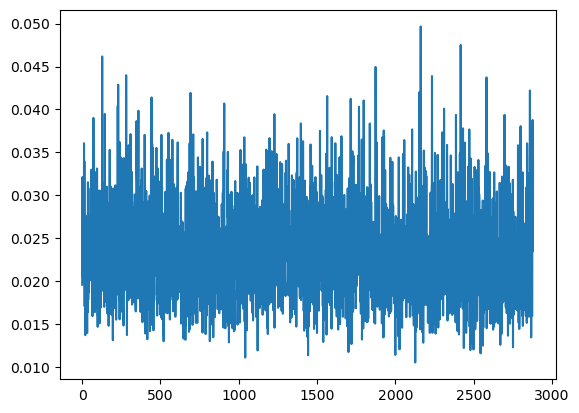

In [20]:
plt.plot(losses)

In [35]:
import gc
torch.cuda.empty_cache()
gc.collect()

8296

In [ ]:
dir(optimizer.optimizer)

In [49]:
torch.save(diffusion_model.state_dict(), f"./diffusion_outputs/model_epoch_{epoch+1}_ckpt.pth")

In [15]:
diffusion_model.eval()

# Initialize the scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

# Function to denormalize images
def denormalize(images):
    return (images * 0.5 + 0.5).clamp(0, 1)

# Function to generate samples with specified attributes
def generate_samples(model, scheduler, num_samples=4, attr_conditions=None):
    """
    Generate samples from the diffusion model with specified attribute conditions
    
    Parameters:
    - model: The diffusion model
    - scheduler: The noise scheduler
    - num_samples: Number of samples to generate
    - attr_conditions: Attribute conditions (one-hot encoded), if None, random attributes will be used
    
    Returns:
    - Generated samples as a tensor
    """
    # Create random noise
    sample_shape = (num_samples, 3, 128, 128)
    noise = torch.randn(sample_shape).to(device)
    
    if attr_conditions is None:
        # Random binary attributes (40 CelebA attributes)
        attr_conditions = torch.randint(0, 2, (num_samples, 40)).to(device)
    else:
        # Make sure we have the right batch dimension
        # If attr_conditions is for a single sample but we want multiple,
        # repeat it to match the number of samples
        if attr_conditions.size(0) == 1 and num_samples > 1:
            attr_conditions = attr_conditions.repeat(num_samples, 1)
        attr_conditions = attr_conditions.to(device)
    
    scheduler.set_timesteps(1000)  # Using fewer steps for faster generation
    
    sample = noise
    
    for t in tqdm(scheduler.timesteps):
        timesteps = torch.full((num_samples,), t, device=device, dtype=torch.long)
        
        with torch.no_grad():
            noise_pred = model(sample, timesteps, attr_conditions)
            
            # Update sample using scheduler
            sample = scheduler.step(noise_pred, t, sample).prev_sample
    
    # Denormalize samples
    sample = denormalize(sample)
    
    return sample


In [16]:
def create_attr_vector(selected_attrs, total_attrs=40):
    """Create a binary attribute vector with 1s at the specified indices"""
    attr_vector = torch.zeros(1, total_attrs)
    for idx in selected_attrs:
        attr_vector[0, idx] = 1.0
    return attr_vector

attr_sets = [
    # Young woman with blonde hair, smiling, attractive
    create_attr_vector([2, 9, 19, 31, 36, 39]),
    
    # Man with glasses and beard
    create_attr_vector([15, 16, 20, 22, 30]),
    
    # Woman with black hair and heavy makeup
    create_attr_vector([2, 8, 18, 36, 39]),
    
    # Person with hat
    create_attr_vector([35, 39])
]

In [21]:
all_samples = []
# for i, attr in enumerate(attr_sets):
#     print(f"Generating samples for attribute set {i+1}...")
#     samples = generate_samples(diffusion_model, noise_scheduler, num_samples=4, attr_conditions=attr)
#     all_samples.append(samples)

# Also generate some samples with random attributes
print("Generating samples with random attributes...")
random_samples = generate_samples(diffusion_model, noise_scheduler, num_samples=4)
all_samples.append(random_samples)



Generating samples with random attributes...


100%|██████████| 1000/1000 [02:47<00:00,  5.96it/s]


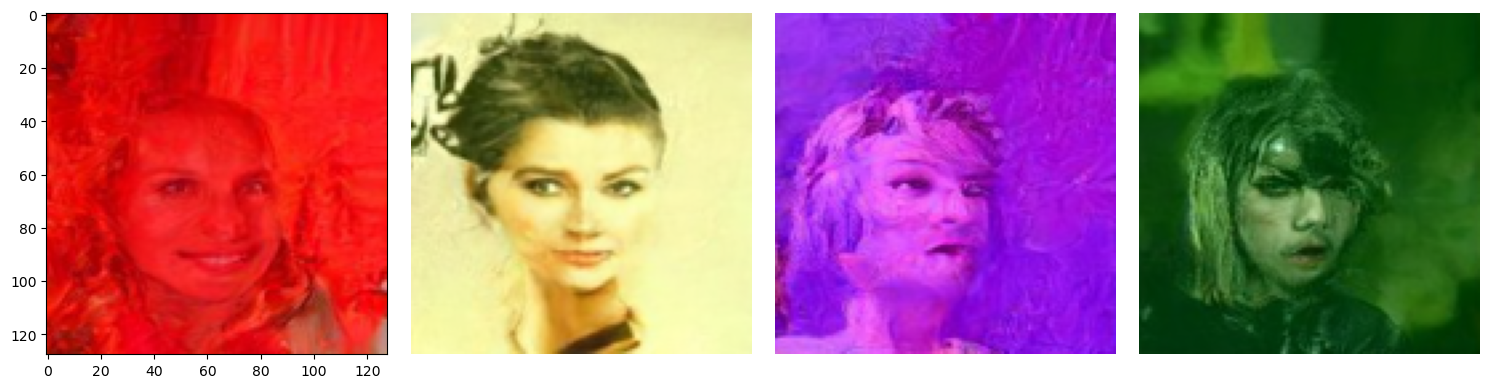

In [22]:
from matplotlib import pyplot as plt
# Plot the results
plt.figure(figsize=(15, 10))

for i, samples in enumerate(all_samples):
    samples = samples.cpu().permute(0, 2, 3, 1).numpy()
    
    for j in range(samples.shape[0]):
        plt.subplot(len(all_samples), 4, i*4 + j + 1)
        plt.imshow(samples[j])
        
        if j == 0:
            if i < len(attr_sets):
                continue # Comment this to show attr-specific generations
                attr_desc = ["Blonde woman", "Man with glasses", "Woman with makeup", "Person with hat"]
                plt.title(f"{attr_desc[i]}")
            else:
                plt.title("Random Attrs")
        
        plt.axis('off')

plt.tight_layout()
# plt.savefig("generated_samples_large_e3_1000.png")
plt.show()

In [ ]:
saved_img_index = 0

In [32]:
# Display individual images from all_samples
save_dir = "./diffusion_outputs/generated/"

from torchvision.utils import save_image


imgs_per_batch = 8
batches = 16

for batch in range(batches):
    random_samples = generate_samples(diffusion_model, noise_scheduler, num_samples=imgs_per_batch)

    # Save images
    for i in range(random_samples.shape[0]):
        img = random_samples[i]
        save_image(img.unsqueeze(0), save_dir + f"img_{saved_img_index}.png", normalize=False)
        saved_img_index += 1

100%|██████████| 1000/1000 [05:33<00:00,  3.00it/s]
